# LabelMe Dataset

* Input patterns: $256\times256$ real RGB images of landscapes.
* Labels: Mutually exclusive types of landscape.
    * Classes: *highway, insidecity, tallbuilding, street, forest, coast, mountain, opencountry*
* Ground truth: The original/real image landscape.
* Annotations: re-collected from Amazon Mechanical Turk (AMT).
    

### What if each annotation comes from a different annotator?
> Global scenario

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    
np.set_printoptions(precision=4, suppress=True)

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder = "./data/LabelMe/"

### Load Data and preprocess

In [4]:
Xstd_train = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

Xstd_val = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

Xstd_test = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",Xstd_train.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


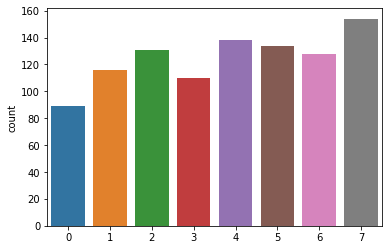

In [5]:
sns.countplot(Z_train)
plt.show()

### Load annotations 

In [6]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers_GLOBAL.txt",dtype='int16') 

N,T = y_obs.shape
print("Shape (data,annotators): ",(N,T))
print("Classes: ",np.max(y_obs)+1)

Loading AMT data...
Shape (data,annotators):  (1000, 2547)
Classes:  8


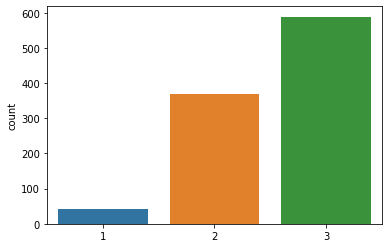

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


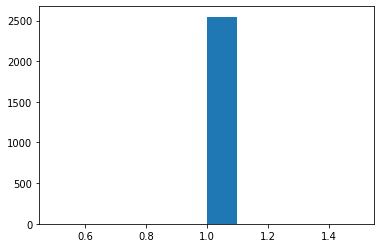

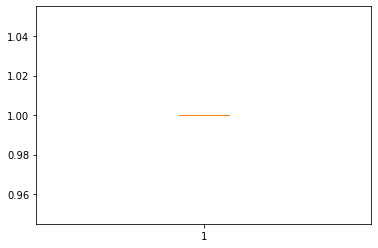

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  1
Mean annotations by an annotator:  1.0


In [7]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

T_weights = np.sum(y_obs != -1,axis=0) 
print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Upper Bound Model -- ideal

In [8]:
#### Delta Convergence criteria
from codeE.learning_models import MLP_Keras, Clonable_Model
from codeE.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

In [9]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
clone_UB = Clonable_Model(model_UB, model_UB.input)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Trained IDeal Model, Epochs to converge = 20


In [11]:
from codeE.evaluation import f1score_model
print("Train accuracy of model =", f1score_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", f1score_model(model_UB, Xstd_test, Z_test))

Train accuracy of model = 0.9595174436553562
Test accuracy of model = 0.9240807160286907


### Generate Matrix representation of both scenarios

In [10]:
from codeE.representation import set_representation

y_obs_categorical = set_representation(y_obs,'onehot') 
print("Individual representation shape (N,T,K)= ",y_obs_categorical.shape)

r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

Individual representation shape (N,T,K)=  (1000, 2547, 8)
Global representation shape (N,K)=  (1000, 8)


### Real Confusion matrices
Generate the individual and global confusion matrices based on the sampled annotations.

In [11]:
from codeE.utils import generate_Individual_conf

conf_matrix_I = generate_Individual_conf(Z_train, y_obs_categorical)
print("Individual matrix shape (T,K,K)= ",conf_matrix_I.shape)
conf_matrix_I

Individual matrix shape (T,K,K)=  (2547, 8, 8)


array([[[0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        ...,
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125]],

       [[0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        ...,
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125]],

       [[0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        ...,
        [0.125, 0.125, 0.125, ..., 0.125, 0.125, 0.125],
        [0.125, 0.125, 0.125, ..., 0.125, 0.1

Global matrix shape (K,K)=  (8, 8)


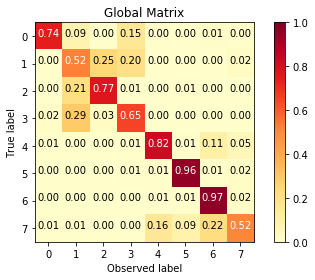

In [12]:
from codeE.utils import generate_Global_conf
confe_matrix_G = generate_Global_conf(Z_train, r_obs)
print("Global matrix shape (K,K)= ",confe_matrix_G.shape)

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(confe_matrix_G, np.arange(8), title= "Global Matrix")

## Aggregation methods (without predictive model)
* Majority Voting (MV)
* Weighted Majority Voting
* Dawid and Skene (DS): with inference

In [13]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="global")

mv_soft = label_A.infer(  r_obs, 'softMV')
mv_hard = label_A.predict(r_obs, 'hardMV')
mv_hard

array([1, 2, 1, 4, 5, 2, 0, 4, 2, 5, 0, 1, 2, 3, 1, 3, 6, 4, 7, 4, 1, 1,
       2, 1, 3, 6, 0, 4, 6, 2, 4, 3, 6, 6, 5, 7, 4, 0, 5, 4, 5, 5, 2, 0,
       4, 2, 1, 5, 1, 6, 1, 7, 1, 0, 1, 6, 6, 7, 4, 4, 2, 3, 0, 5, 1, 1,
       4, 5, 2, 6, 4, 1, 7, 6, 6, 1, 5, 6, 6, 4, 1, 3, 6, 5, 4, 5, 6, 4,
       0, 4, 7, 0, 3, 3, 5, 5, 7, 4, 1, 3, 5, 4, 4, 1, 7, 7, 6, 2, 4, 2,
       2, 1, 7, 4, 0, 7, 7, 4, 0, 1, 6, 4, 7, 7, 2, 2, 2, 4, 1, 3, 1, 6,
       0, 6, 6, 1, 6, 0, 4, 6, 0, 3, 0, 5, 7, 0, 4, 3, 2, 3, 4, 0, 5, 6,
       4, 3, 0, 6, 1, 7, 3, 1, 7, 2, 1, 7, 0, 3, 5, 5, 1, 0, 5, 2, 6, 2,
       5, 4, 2, 5, 5, 2, 5, 4, 3, 3, 6, 4, 0, 1, 0, 4, 7, 2, 5, 0, 7, 4,
       1, 0, 0, 5, 0, 3, 6, 4, 1, 7, 1, 1, 1, 4, 6, 5, 5, 4, 1, 6, 1, 2,
       1, 5, 5, 4, 4, 7, 2, 0, 2, 0, 1, 5, 2, 4, 3, 5, 6, 6, 1, 1, 4, 1,
       6, 4, 2, 6, 2, 7, 5, 4, 3, 4, 2, 7, 6, 4, 2, 1, 5, 7, 3, 3, 5, 6,
       1, 6, 6, 1, 7, 3, 5, 2, 6, 5, 1, 1, 6, 1, 1, 5, 1, 4, 4, 1, 5, 3,
       6, 2, 6, 4, 3, 6, 1, 4, 1, 3, 6, 0, 2, 6, 0,

In [14]:
print("ACC MV on train:",np.mean(mv_hard==Z_train))

ACC MV on train: 0.769


### generate confusion matrix to understand MV

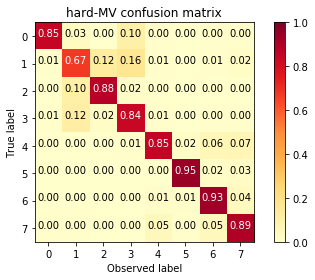

In [15]:
from codeE.utils import generate_confusionM
prob_Yz = generate_confusionM(mv_hard, r_obs) #confusion matrix of all annotators
plot_confusion_matrix(prob_Yz, np.arange(8), title= "hard-MV confusion matrix")

### Metrics to compare the estimation of confusion matrix

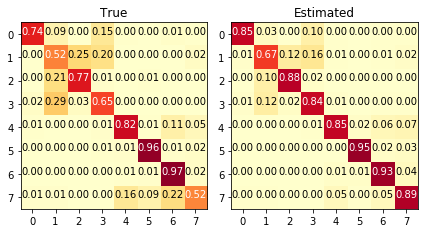

In [16]:
from codeE.utils import compare_conf_ma
compare_conf_ma(prob_Yz, true_conf_mat=confe_matrix_G, text=True)

In [17]:
from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.03469416227325334
Global D (based on normalized Frobenius) = 0.07360906898975372


##### Weighted

In [18]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="individual")

Wmv_soft = label_A.infer(y_obs_categorical, 'softMV', weights=T_weights)
Wmv_soft

array([[0.    , 0.6667, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3333, 0.6667, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3333, 0.3333, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.3333, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [19]:
print("ACC MV on train:",np.mean(Wmv_soft.argmax(axis=-1)==Z_train))

ACC MV on train: 0.769


### Dawid and Skene model

In [20]:
from codeE.methods import LabelInf_EM as DS

DS_model = DS(init_Z='softmv') 
#DS_model = DS(init_Z='softmv', priors="None", fast=False) 
    
hist = DS_model.fit(y_obs_categorical, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Z marginal shape (8,)
Betas shape:  (2547, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -1736.469	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: 0.001	Tol1: 1.00000	Tol2: 1.44588	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: 0.003	Tol1: 1.85504	Tol2: 0.00000	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: 0.001	Tol1: 0.77185	Tol2: 0.00000	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: 0.000	Tol1: 0.40683	Tol2: 0.00000	
Iter 6/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: 0.000	Tol1: 0.00000	Tol2: 0.00000	
Finished training


In [21]:
print("p(z) = ",DS_model.get_marginalZ())

ds_labels = DS_model.infer() #could infer/predict on the trainint set only
ds_labels

p(z) =  [0.0628 0.1393 0.1319 0.1116 0.1416 0.1437 0.1834 0.0856]


array([[0.0628, 0.1393, 0.1319, ..., 0.1437, 0.1834, 0.0856],
       [0.0628, 0.1393, 0.1319, ..., 0.1437, 0.1834, 0.0856],
       [0.0628, 0.1393, 0.1319, ..., 0.1437, 0.1834, 0.0856],
       ...,
       [0.0628, 0.1393, 0.1319, ..., 0.1437, 0.1834, 0.0856],
       [0.0628, 0.1393, 0.1319, ..., 0.1437, 0.1834, 0.0856],
       [0.0628, 0.1393, 0.1319, ..., 0.1437, 0.1834, 0.0856]],
      dtype=float32)

In [22]:
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC D&S on train: 0.128


### Second Phase
train a predictive model over the inference/aggregation label

In [23]:
from codeE.evaluation import accuracy_model

In [24]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvsoft, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvsoft, Xstd_test, Z_test))

Trained model over soft-MV, Epochs to converge = 9
Train accuracy of model = 0.834
Test accuracy of model = 0.8223905723905723


In [25]:
mv_hard_onehot = keras.utils.to_categorical(mv_hard)
mv_hard_onehot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [26]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_hard_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvhard, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvhard, Xstd_test, Z_test))

Trained model over hard-MV, Epochs to converge = 9
Train accuracy of model = 0.822
Test accuracy of model = 0.8164983164983165


In [27]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_ds, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_ds, Xstd_test, Z_test))

Trained model over D&S, Epochs to converge = 6
Train accuracy of model = 0.138
Test accuracy of model = 0.11868686868686869


## Raykar Model (joint predict model)

In [28]:
model_R = clone_UB.get_model()
model_R.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [29]:
from codeE.methods import ModelInf_EM as Raykar
R_model = Raykar(init_Z="softmv")
#R_model = Raykar(init_Z="softmv", priors='laplace', n_init_Z=3)

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
R_model.set_model(model_R, **args)
R_model.fit(Xstd_train, y_obs_categorical, runs=20, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Betas shape:  (2547, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.61 sec)	logL: -793.887	
Iter 2/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: 0.001	Tol1: 1.00000	Tol2: 1.44588	
Iter 3/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: 0.001	Tol1: 0.00035	Tol2: 0.00000	
Finished training
Initializing new EM...
Betas shape:  (2547, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.45 sec)	logL: -695.705	
Iter 2/50 
M step: done,  E step: done //  (in 0.07 sec)	logL: 0.001	Tol1: 1.00000	Tol2: 1.44588	
Iter 3/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: 0.001	Tol1: 0.00218	Tol2: 0.00000	
Finished training
Initializing new EM...
Betas shape:  (2547, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.47 sec)	logL: -804.946	
Iter 2/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: 0.001	Tol1: 1.00000	Tol2: 1.44588	
Iter 3/50 
M step:

([[-793.8873291015625, 0.0013655417133122683, 0.0013660185504704714],
  [-695.70458984375, 0.0013693564105778933, 0.0013663761783391237],
  [-804.946044921875, 0.0013641112018376589, 0.0013674490619450808],
  [-820.9505004882812, 0.0013670914340764284, 0.001368998782709241],
  [-807.047119140625, 0.0013692372012883425, 0.0013670914340764284],
  [-666.3829345703125, 0.0013685219455510378, 0.0013720982242375612],
  [-866.5380859375, 0.0013668530154973269, 0.0013681643176823854],
  [-718.1636962890625, 0.0013693564105778933, 0.0013649455504491925],
  [-808.7967529296875, 0.0013710253406316042, 0.001365660922601819],
  [-852.8248901367188, 0.0013706677127629519, 0.0013680451083928347],
  [-742.9029541015625, 0.0013647072482854128, 0.0013666145969182253],
  [-853.8323974609375, 0.0013663761783391237, 0.0013686411548405886],
  [-898.5785522460938, 0.0013617270160466433, 0.0013658993411809206],
  [-878.9320678710938, 0.0013681643176823854, 0.0013685219455510378],
  [-686.66015625, 0.001365184

In [30]:
raykar_fx = R_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(raykar_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(raykar_fx, Xstd_test, Z_test))

Train accuracy of model = 0.793
Test accuracy of model = 0.7609427609427609


## Our Proposed - CMM

In [31]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [32]:
from codeE.methods import ModelInf_EM_CMM as  CMM
CMM_model = CMM(M=M_seted) 
#CMM_model = CMM(M=M_seted, init_Z='softmv', n_init_Z=3, priors=0) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMM_model.set_model(aux_model, **args)

CMM_model.fit(Xstd_train, r_obs, runs =20,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.78 sec)	logL: -2749.252	
Iter 2/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2051.164	Tol1: 0.25392	Tol2: 0.83382	Tol3: 0.01528	
Iter 3/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1838.920	Tol1: 0.10347	Tol2: 0.33515	Tol3: 0.03293	
Iter 4/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1768.597	Tol1: 0.03824	Tol2: 0.23118	Tol3: 0.02227	
Iter 5/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1683.213	Tol1: 0.04828	Tol2: 0.21712	Tol3: 0.03925	
Iter 6/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1629.076	Tol1: 0.03216	Tol2: 0.18862	Tol3: 0.03415	
Iter 7/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1596.699	Tol1: 0.01987	Tol2: 0.15899	Tol3: 0.02042	
Iter 8/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1568.714	Tol1: 0.01753	Tol2: 0.11882	Tol3: 0.01078	
Iter 9/50
M s

M step: done,  E step: done //  (in 0.04 sec)	logL: -1351.919	Tol1: 0.01210	Tol2: 0.05481	Tol3: 0.01496	
Iter 21/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1339.425	Tol1: 0.00924	Tol2: 0.05734	Tol3: 0.00965	
Iter 22/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1327.354	Tol1: 0.00901	Tol2: 0.04949	Tol3: 0.00643	
Iter 23/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1314.791	Tol1: 0.00946	Tol2: 0.04743	Tol3: 0.01214	
Iter 24/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1300.468	Tol1: 0.01089	Tol2: 0.04521	Tol3: 0.01197	
Iter 25/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1287.433	Tol1: 0.01002	Tol2: 0.04762	Tol3: 0.01117	
Iter 26/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1273.736	Tol1: 0.01064	Tol2: 0.04993	Tol3: 0.01276	
Iter 27/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1262.246	Tol1: 0.00902	Tol2: 0.04179	Tol3: 0.00548	
Iter 28/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1251.219	Tol1: 0.00

M step: done,  E step: done //  (in 0.04 sec)	logL: -1838.102	Tol1: 0.04102	Tol2: 0.25220	Tol3: 0.01499	
Iter 5/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1781.952	Tol1: 0.03055	Tol2: 0.20841	Tol3: 0.02495	
Iter 6/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1740.132	Tol1: 0.02347	Tol2: 0.18154	Tol3: 0.01447	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.090	Tol1: 0.02416	Tol2: 0.17546	Tol3: 0.01165	
Iter 8/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1666.119	Tol1: 0.01883	Tol2: 0.15603	Tol3: 0.01419	
Iter 9/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1635.659	Tol1: 0.01828	Tol2: 0.12972	Tol3: 0.01952	
Iter 10/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1605.472	Tol1: 0.01846	Tol2: 0.10697	Tol3: 0.01441	
Iter 11/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1576.742	Tol1: 0.01790	Tol2: 0.09915	Tol3: 0.01513	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1562.780	Tol1: 0.00885	T

M step: done,  E step: done //  (in 0.04 sec)	logL: -1591.021	Tol1: 0.01853	Tol2: 0.14697	Tol3: 0.00900	
Iter 11/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1565.763	Tol1: 0.01588	Tol2: 0.13298	Tol3: 0.01182	
Iter 12/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1536.167	Tol1: 0.01890	Tol2: 0.11611	Tol3: 0.01679	
Iter 13/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1517.690	Tol1: 0.01203	Tol2: 0.09617	Tol3: 0.00832	
Iter 14/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1495.692	Tol1: 0.01449	Tol2: 0.09109	Tol3: 0.01017	
Iter 15/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1471.174	Tol1: 0.01639	Tol2: 0.05894	Tol3: 0.00507	
Iter 16/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1444.528	Tol1: 0.01811	Tol2: 0.06445	Tol3: 0.01182	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1432.169	Tol1: 0.00856	Tol2: 0.07209	Tol3: 0.03020	
Iter 18/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1412.426	Tol1: 0.01

M step: done,  E step: done //  (in 0.03 sec)	logL: -1810.583	Tol1: 0.04635	Tol2: 0.20645	Tol3: 0.02995	
Iter 5/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1719.979	Tol1: 0.05004	Tol2: 0.18033	Tol3: 0.01800	
Iter 6/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1661.843	Tol1: 0.03380	Tol2: 0.18953	Tol3: 0.00909	
Iter 7/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1612.120	Tol1: 0.02992	Tol2: 0.17331	Tol3: 0.01571	
Iter 8/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1565.579	Tol1: 0.02887	Tol2: 0.15522	Tol3: 0.02517	
Iter 9/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1527.760	Tol1: 0.02416	Tol2: 0.11122	Tol3: 0.01616	
Iter 10/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1498.433	Tol1: 0.01920	Tol2: 0.09937	Tol3: 0.00734	
Iter 11/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1474.142	Tol1: 0.01621	Tol2: 0.08268	Tol3: 0.00169	
Iter 12/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1455.291	Tol1: 0.01279	T

([array([-2749.2524, -2051.1641, -1838.9199, -1768.5972, -1683.2128,
         -1629.0761, -1596.6987, -1568.7135, -1538.9174, -1514.4682,
         -1493.358 , -1473.2814, -1454.8954, -1437.8534, -1424.0609,
         -1407.3729, -1393.8698, -1385.5195, -1373.2008, -1355.3529,
         -1341.2071, -1328.0325, -1318.7002, -1305.887 , -1299.7555,
         -1287.8835, -1278.8388, -1263.2755, -1256.4845, -1246.4553,
         -1233.7278, -1224.4618, -1216.3056, -1210.9109]),
  array([-3228.0834, -2135.8892, -1894.7336, -1798.1341, -1733.956 ,
         -1692.085 , -1657.1035, -1619.9148, -1585.2279, -1557.1367,
         -1529.6662, -1501.8015, -1479.4803, -1454.1405, -1436.9698,
         -1418.4514, -1401.2702, -1380.7748, -1365.3573, -1349.1737,
         -1331.7598, -1314.0816, -1300.0126, -1285.6805, -1271.1098,
         -1259.724 , -1247.5006]),
  array([-2713.3328, -1998.4191, -1848.9933, -1788.9685, -1736.1381,
         -1697.4888, -1657.2363, -1626.8696, -1594.7622, -1566.5272,
         

In [33]:
cmm_fx = CMM_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmm_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmm_fx, Xstd_test, Z_test))

Train accuracy of model = 0.828
Test accuracy of model = 0.835016835016835


### Groups found

In [41]:
print("p(g) =",CMM_model.get_alpha())

p(g) = [0.9824 0.0142 0.0034]


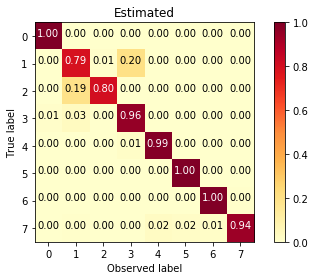

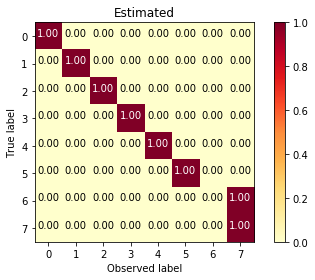

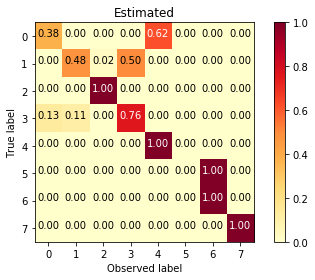

In [42]:
B = CMM_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

## Our Proposed - C-MoA

#### Auxiliar representation with variable number of annotations per annotator and identity

In [34]:
y_cat_var, A_idx_var = set_representation(y_obs,"onehotvar")
print("Individual sparse representation, variable shape (N,)= ",y_cat_var.shape)
K = y_cat_var[0].shape[1]
print("one-hot vectors of K-dimensions, K=",K)
y_cat_var

Individual sparse representation, variable shape (N,)=  (1000,)
one-hot vectors of K-dimensions, K= 8


array([array([[0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0]], dtype=int8),
       array([[0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8),
       array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0

In [54]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


#### Fixed annotators representation (non trainable embedding)

In [55]:
T= np.concatenate(A_idx_var).max() +1
A_rep = np.zeros((T, K))
for i in range(N):
    for l, t_idx in enumerate(A_idx_var[i]):
        obs_t = y_cat_var[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
print("shape of annotator representation (T, R_t)=", A_rep.shape)

shape of annotator representation (T, R_t)= (2547, 8)


In [56]:
from keras.models import Sequential
from keras.layers import *
group_model = Sequential()
group_model.add(Embedding(T, K, input_length=1, 
                         trainable=False,weights=[A_rep]))
group_model.add(Reshape([K]))
group_model.add(Dense(K*M_seted, activation='relu'))
group_model.add(Dense(M_seted, activation='softmax'))
group_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 8)              20376     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 75        
Total params: 20,667
Trainable params: 291
Non-trainable params: 20,376
_________________________________________________________________


In [57]:
from codeE.methods import ModelInf_EM_CMOA as CMOA
CMOA_model = CMOA(M=M_seted) 
#CMOA_model = CMOA(M=M_seted, init_Z='softmv', n_init_Z=0, n_init_G=0, priors=1) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMOA_model.set_model(aux_model, ann_model=group_model, **args)
#CMOA_model.set_model(group_model) #you also can set it manually

CMOA_model.fit(Xstd_train, y_cat_var, A_idx_var, runs = 20,max_iter=EPOCHS_BASE,tolerance=TOL) 

Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 1.38 sec)	logL: -4012.802	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -3359.337	Tol1: 0.16285	Tol2: 2.70462	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -3053.794	Tol1: 0.09095	Tol2: 4.90860	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2821.659	Tol1: 0.07602	Tol2: 4.85918	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2475.968	Tol1: 0.12251	Tol2: 2.84533	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2114.167	Tol1: 0.14613	Tol2: 0.95110	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1922.635	Tol1: 0.09059	Tol2: 0.44716	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1814.048	Tol1: 0.05648	Tol2: 0.34891	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1723.469	Tol1: 0.04993	Tol2: 0.28853	
Iter 10/50
M step: done,  E

(array([-4012.8021, -3359.3366, -3053.7938, -2821.6589, -2475.968 ,
        -2114.167 , -1922.6352, -1814.0479, -1723.4693, -1648.9949,
        -1583.3138, -1520.1239, -1451.8788, -1390.1403, -1344.1478,
        -1302.4371, -1265.0557, -1225.7118, -1196.1315, -1165.8066,
        -1138.9148, -1108.1409, -1077.2686, -1045.2801, -1017.0046,
         -987.6255,  -961.2188,  -932.227 ,  -904.5945,  -877.8952,
         -853.848 ,  -830.7963,  -806.5854,  -784.9778,  -765.3867,
         -747.0896,  -725.3646,  -707.2915,  -688.9606,  -672.3577,
         -658.5021,  -641.9039,  -626.4209,  -612.4844,  -598.072 ,
         -585.0019,  -571.2756,  -561.3175,  -548.9789,  -538.4161]),
 0)

In [39]:
cmoaK_fx = CMOA_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmoaK_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmoaK_fx, Xstd_test, Z_test))

Train accuracy of model = 0.852
Test accuracy of model = 0.8501683501683501


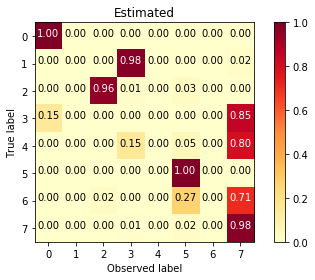

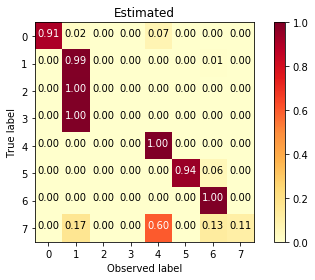

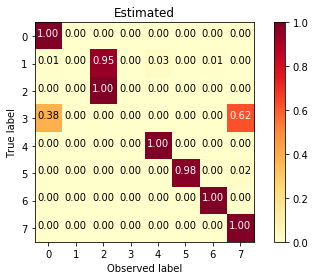

In [50]:
B = CMOA_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

## Global Behavior - Label Noise

In [40]:
aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [41]:
from codeE.methods import ModelInf_EM_G as G_Noise
GNoise_model = G_Noise() 
args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
GNoise_model.set_model(aux_model, **args)

GNoise_model.fit(Xstd_train, r_obs, runs =20,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Beta:  (8, 8)
Q estimate:  (1000, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -2497.264	
Iter 2/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1975.283	Tol1: 0.20902	Tol2: 0.35826	
Iter 3/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1822.978	Tol1: 0.07711	Tol2: 0.24488	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1760.266	Tol1: 0.03440	Tol2: 0.21670	
Iter 5/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1719.360	Tol1: 0.02324	Tol2: 0.15001	
Iter 6/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1688.752	Tol1: 0.01780	Tol2: 0.12519	
Iter 7/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1664.692	Tol1: 0.01425	Tol2: 0.09321	
Iter 8/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1639.339	Tol1: 0.01523	Tol2: 0.07923	
Iter 9/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1617.086	Tol1: 0.01357	Tol2: 0.08064	
Iter 10/50
M step: done,  E step: done //  (in 0.04 sec)	lo

M step: done,  E step: done //  (in 0.04 sec)	logL: -1514.806	Tol1: 0.00589	Tol2: 0.04016	
Iter 15/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1504.172	Tol1: 0.00702	Tol2: 0.04174	
Iter 16/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1495.119	Tol1: 0.00602	Tol2: 0.03831	
Iter 17/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1487.271	Tol1: 0.00525	Tol2: 0.02741	
Finished training!
Initializing new EM...
Beta:  (8, 8)
Q estimate:  (1000, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -2393.604	
Iter 2/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1915.410	Tol1: 0.19978	Tol2: 0.34622	
Iter 3/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1793.417	Tol1: 0.06369	Tol2: 0.23661	
Iter 4/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1719.092	Tol1: 0.04144	Tol2: 0.17232	
Iter 5/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1677.213	Tol1: 0.02436	Tol2: 0.18832	
Iter 6/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.04 sec)	logL: -1675.949	Tol1: 0.01913	Tol2: 0.11997	
Iter 6/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1652.515	Tol1: 0.01398	Tol2: 0.08741	
Iter 7/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1635.921	Tol1: 0.01004	Tol2: 0.07449	
Iter 8/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1618.332	Tol1: 0.01075	Tol2: 0.06111	
Iter 9/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1603.424	Tol1: 0.00921	Tol2: 0.05582	
Iter 10/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1592.794	Tol1: 0.00663	Tol2: 0.04471	
Iter 11/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1583.367	Tol1: 0.00592	Tol2: 0.05078	
Iter 12/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1572.322	Tol1: 0.00698	Tol2: 0.06249	
Iter 13/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1559.921	Tol1: 0.00789	Tol2: 0.04617	
Iter 14/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1552.765	Tol1: 0.00459	Tol2: 0.03

([array([-2497.2639, -1975.2826, -1822.978 , -1760.2662, -1719.3604,
         -1688.7523, -1664.6921, -1639.3394, -1617.0857, -1601.0999,
         -1589.1434, -1574.0103, -1561.7321, -1550.4441]),
  array([-2372.6404, -1896.9658, -1795.3145, -1747.1128, -1706.7548,
         -1676.7444, -1650.7896, -1631.0591, -1614.2102, -1595.3655,
         -1579.0149, -1564.9554, -1551.7542, -1540.9839, -1530.2582,
         -1521.9863, -1512.8406]),
  array([-2309.6843, -1883.6606, -1741.1052, -1681.4995, -1648.7615,
         -1629.7605, -1604.1903, -1589.5793, -1575.0426, -1562.179 ,
         -1548.3912, -1538.4744, -1529.6715]),
  array([-2358.709 , -1965.524 , -1803.8403, -1715.0243, -1677.365 ,
         -1647.1316, -1622.8164, -1599.3883, -1581.6156, -1570.1744,
         -1556.8264]),
  array([-2503.592 , -1916.2043, -1746.3438, -1694.8345, -1661.224 ,
         -1632.9614, -1611.0391, -1596.5129, -1577.2517, -1565.4578]),
  array([-2454.4248, -1903.5231, -1748.6056, -1694.446 , -1658.0415,
      

In [42]:
G_fx = GNoise_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(G_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(G_fx, Xstd_test, Z_test))

Train accuracy of model = 0.861
Test accuracy of model = 0.8417508417508418


## Confusion Matrices Visualization

In [43]:
from codeE.utils import generate_confusionM
from codeE.utils import plot_confusion_matrix, compare_conf_ma, compare_set_conf_ma
from codeE.evaluation import Individual_D, D_JS, D_NormF

### Global scenario

#### MV

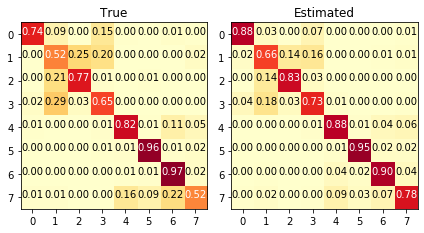

Global D (based on Jensen Shannon) = 0.024224901133546403
Global D (based on normalized Frobenius) = 0.05655808001756668


In [44]:
### SOFT
prob_Yz = generate_confusionM(mv_soft, r_obs) #confusion matrix of all annotations
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

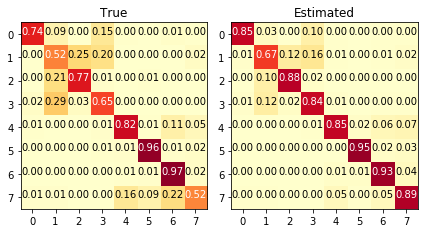

Global D (based on Jensen Shannon) = 0.03469416227325334
Global D (based on normalized Frobenius) = 0.07360906898975372


In [45]:
### HARD
prob_Yz = generate_confusionM(mv_hard, r_obs) 
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### CMM

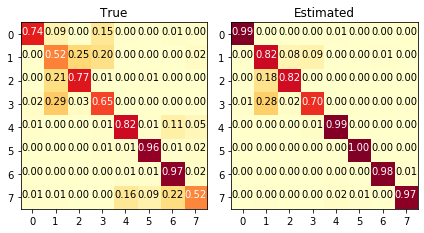

Global D (based on Jensen Shannon) = 0.07502800513789586
Global D (based on normalized Frobenius) = 0.09337748687358932


In [46]:
prob_Yz = CMM_model.get_global_confusionM()

compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### Global - Label Noise

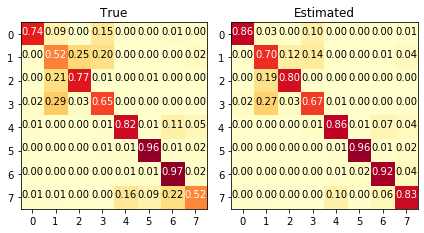

Global D (based on Jensen Shannon) = 0.024281980563030416
Global D (based on normalized Frobenius) = 0.05803265795111656


In [47]:
prob_Yz = GNoise_model.get_global_confusionM()
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

### Individual scenario

#### DS

Plot 5 random matrices from the set


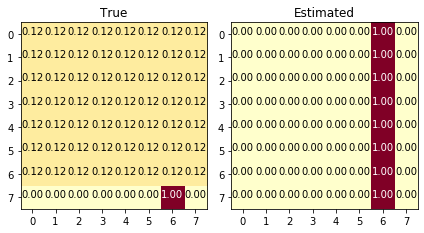

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


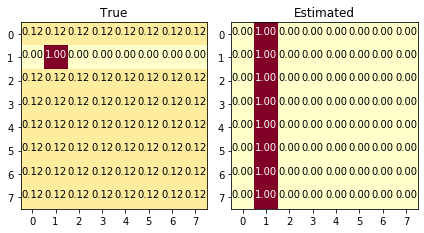

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


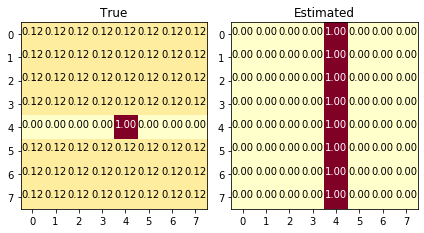

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


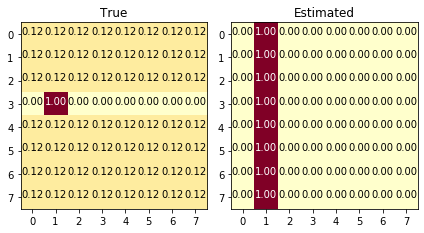

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


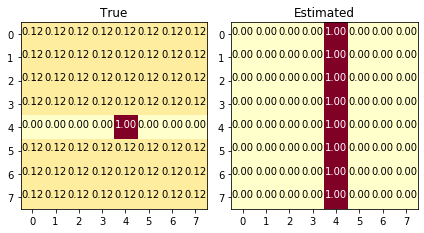

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


In [48]:
prob_Yzt = DS_model.get_ann_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [49]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.6272959271107255
Individual D_NormF =  0.30935922265052795


#### Raykar

Plot 5 random matrices from the set


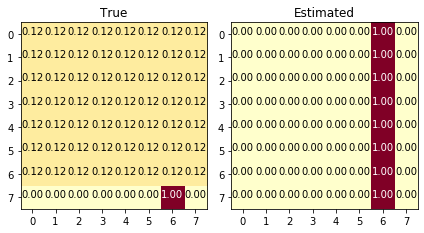

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


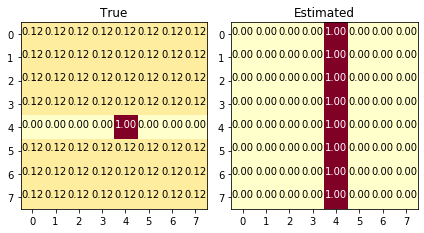

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


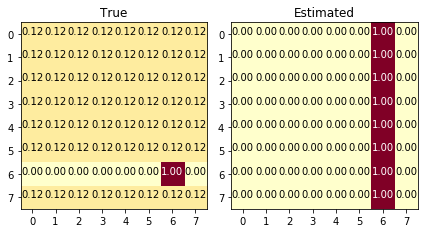

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


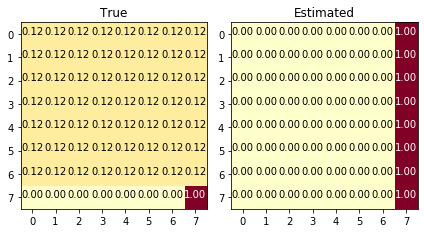

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


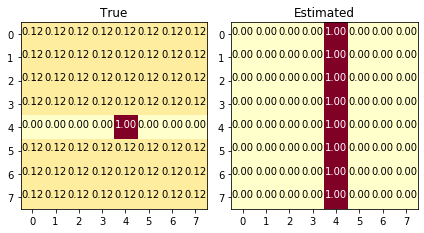

D (based on Jensen Shannon) = 0.6272959271107529
D (based on normalized Frobenius) = 0.30935922265052795


In [50]:
prob_Yzt = R_model.get_ann_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [51]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.6272959271107255
Individual D_NormF =  0.30935922265052795


#### C-MoA

Plot 5 random matrices from the set


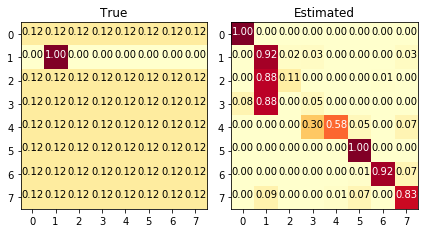

D (based on Jensen Shannon) = 0.5150731676393212
D (based on normalized Frobenius) = 0.2704113987527948


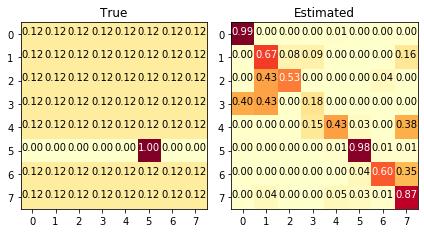

D (based on Jensen Shannon) = 0.4277395633516094
D (based on normalized Frobenius) = 0.21835390295367835


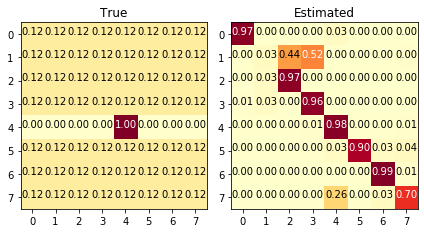

D (based on Jensen Shannon) = 0.52452742441626
D (based on normalized Frobenius) = 0.2729409485464286


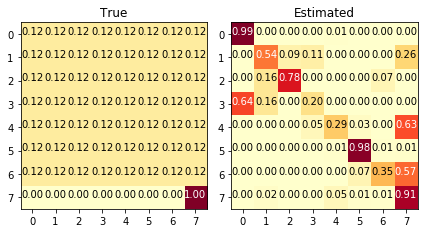

D (based on Jensen Shannon) = 0.45730569029366364
D (based on normalized Frobenius) = 0.23453653231280092


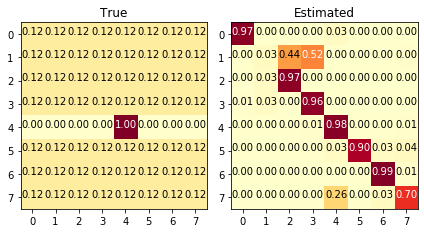

D (based on Jensen Shannon) = 0.52452742441626
D (based on normalized Frobenius) = 0.2729409485464286


In [58]:
A = np.unique(np.concatenate(A_idx_var)).reshape(-1,1)
prob_Yzt = CMOA_model.get_ann_confusionM(A) # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [59]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.5079117051024999
Individual D_NormF =  0.2632123479836363


#### CMM could estimates individual matrices 

Plot 5 random matrices from the set


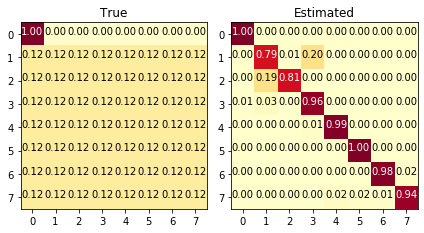

D (based on Jensen Shannon) = 0.5545215634312639
D (based on normalized Frobenius) = 0.2855641558743707


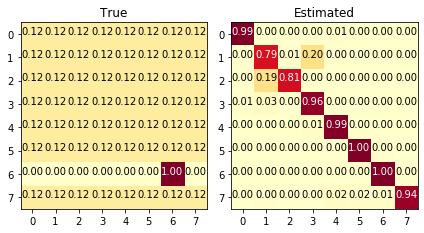

D (based on Jensen Shannon) = 0.5560506296221148
D (based on normalized Frobenius) = 0.28585199762364216


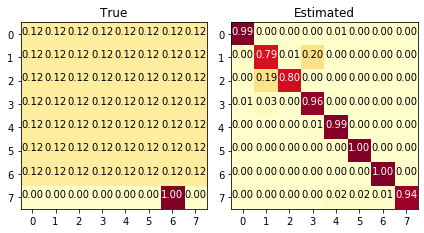

D (based on Jensen Shannon) = 0.6882040536439957
D (based on normalized Frobenius) = 0.3352361461041699


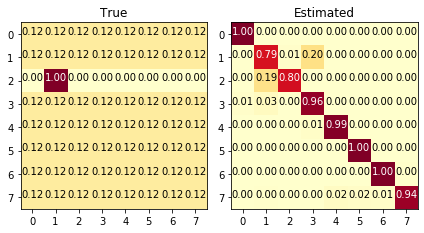

D (based on Jensen Shannon) = 0.6512463296596318
D (based on normalized Frobenius) = 0.3270546857630906


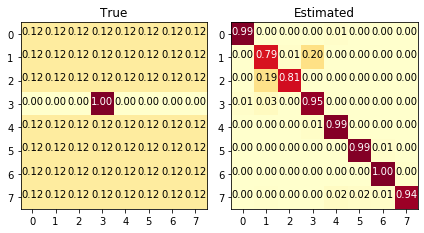

D (based on Jensen Shannon) = 0.5651375767710858
D (based on normalized Frobenius) = 0.2875935904970011


In [61]:
prob_Yzt = []
for t in range(y_obs.shape[1]):
    conf = CMM_model.get_ann_confusionM(Xstd_train, y_obs[:,t])
    
    prob_Yzt.append(conf)
prob_Yzt = np.asarray(prob_Yzt)

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [62]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.5928859369497145
Individual D_NormF =  0.2998490464453537


#### C-MoA could estimates global matrices 

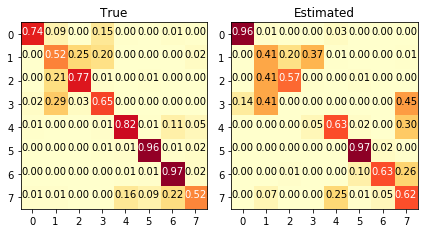

In [63]:
A = np.unique(np.concatenate(A_idx_var)).reshape(-1,1)
prob_Gt = CMOA_model.get_predictions_g(A)

prob_Yz = CMOA_model.get_global_confusionM(prob_Gt)

compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

In [64]:
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.1530580611074031
Global D (based on normalized Frobenius) = 0.1372034951703879
